In [1]:
import pandas as pd
import numpy as np
from itertools import chain
import pickle
import time
import networkx as nx

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
from joblib import Parallel, delayed
import random
import itertools
import math

## 生成会话序列并通过随机游走生成游走序列 保存

In [6]:
def cnt_session(data, time_cut=30, cut_type=2):
    sku_list = data['sku_id']
    time_list = data['action_time']
    type_list = data['type']
    session = []
    tmp_session = []
    for i, item in enumerate(sku_list):
        if type_list[i] == cut_type or (i < len(sku_list)-1 and (time_list[i+1]-time_list[i]).seconds/60>time_cut) or i == len(sku_list) - 1:
            tmp_session.append(item)
            session.append(tmp_session)
            tmp_session = []
        else:
            tmp_session.append(item)
    return session
def get_session(action_data, use_type=None):
    if use_type is None:
        use_type = [1, 2, 3, 5]
    action_data = action_data[action_data['type'].isin(use_type)]
    action_data = action_data.sort_values(by=['user_id', 'action_time'], ascending=True)
    group_action_data = action_data.groupby('user_id').agg(list)
    session_list = group_action_data.apply(cnt_session, axis=1)
    return session_list.to_numpy()
def get_graph_context_all_pairs(walks, window_size):
    all_pairs = []
    for k in range(len(walks)):
        for i in range(len(walks[k])):
            for j in range(i - window_size, i + window_size + 1):
                if i == j or j < 0 or j >= len(walks[k]):
                    continue
                else:
                    all_pairs.append([walks[k][i], walks[k][j]])
    return np.array(all_pairs, dtype=np.int32)

In [ ]:
action_data = pd.read_csv('./action_head.csv', parse_dates=['action_time']).drop('module_id', axis=1).dropna()
all_skus = action_data['sku_id'].unique()
all_skus = pd.DataFrame({'sku_id':list(all_skus)})
sku_lbe = LabelEncoder()
all_skus['sku_id'] = sku_lbe.fit_transform(all_skus['sku_id'])
action_data['sku_id'] = sku_lbe.fit_transform(action_data['sku_id'])

print('make session list\n')
start_time = time.time()
session_list = get_session(action_data, use_type=[1, 2, 3, 5])
session_list_all = []
for item_list in session_list:
    for session in item_list:
        if len(session) > 1:
            session_list_all.append(session)
print('make session list done, time cost {0}'.format(str(time.time() - start_time)))

#session2graph
node_pair = dict()
for session in session_list_all:
    for i in range(1, len(session)):
        if (session[i-1], session[i]) not in node_pair.keys():
            node_pair[(session[i-1], session[i])] = 1
        else:
            node_pair[(session[i-1], session[i])] += 1
in_node_list = list(map(lambda x:x[0], list(node_pair.keys())))
out_node_list = list(map(lambda x:x[1], list(node_pair.keys())))
weight_list = list(node_pair.values())
graph_df = pd.DataFrame({'in_node':in_node_list, 'out_node':out_node_list, 'weight':weight_list})
graph_df.to_csv('./graph.csv', sep=' ', index=False, header=False)

G = nx.read_edgelist('./graph.csv', create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])
walker = RandomWalker(G, p=0.25, q=2)
print('Preprocess transition probs...')
walker.preprocess_transition_probs()

session_reproduce = walker.simulate_walks(num_walks=3, walk_length=10, workers=4, verbose=1)
session_reproduce = list(filter(lambda x:len(x) > 2, session_reproduce))

#add side info
product_data = pd.read_csv('./jdata_product.csv').drop('market_time', axis=1).dropna()
all_skus['sku_id'] = sku_lbe.inverse_transform(all_skus['sku_id'])
print('sku nums:' + str(all_skus.count()))
sku_side_info = pd.merge(all_skus, product_data, on='sku_id', how='left').fillna(0)

#id2idx
for feat in sku_side_info.columns:
    if feat != 'sku_id':
        lbe = LabelEncoder()
        sku_side_info[feat] = lbe.fit_transform(sku_side_info[feat])
    else:
        sku_side_info[feat] = sku_lbe.transform(sku_side_info[feat])

sku_side_info = sku_side_info.sort_values(by=['sku_id'], ascending=True)
sku_side_info.to_csv('./sku_side_info.csv', index=False, header=False, sep='\t')

#get pair
all_pairs = get_graph_context_all_pairs(session_reproduce, 5)
np.savetxt('./all_pairs', X=all_pairs, fmt='%d', delimiter=" ")

## 随机游走算法

In [7]:
def create_alias_table(area_ratio):
    l = len(area_ratio)
    area_ratio = [prob * l for prob in area_ratio]
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    
    for i, prob in enumerate(area_ratio):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)
    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio[small_idx]
        alias[small_idx] = large_idx
        area_ratio[large_idx] = area_ratio[large_idx] - (1- area_ratio[small_idx])
        if area_ratio[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)
    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1
    return accept, alias
def alias_sample(accept, alias):
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

In [8]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

In [9]:
class RandomWalker:
    def __init__(self, G, p=1, q=1):
        self.G = G
        self.p = p
        self.q = q
    def deepwalk_walk(self, walk_length, start_node):
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(self.G.neighbors(cur))
            if len(cur_nbrs) > 0:
                walk.append(random.choice(cur_nbrs))
            else:
                break
        return walk
    def node2vec_walk(self, walk_length, start_node):
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges
        
        walk = [start_node]
        
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    edge = (prev, cur)
                    next_node = cur_nbrs[alias_sample(alias_edges[edge][0], alias_edges[edge][1])]
                    walk.append(next_node)
            else:
                break
        return walk
    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):
        G = self.G
        nodes = list(G.nodes())
        
        results = Parallel(n_jobs=workers, verbose=verbose,)(delayed(self._simulate_walks)(nodes, num, walk_length) for num in 
                                                           partition_num(num_walks, workers))
        walks = list(itertools.chain(*results))
        return walks
    def _simulate_walks(self, nodes, num_walks, walk_length,):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(walk_length=walk_length, start_node=v))
                else:
                    walks.append(self.node2vec_walk(walk_length-walk_length, start_node=v))
        return walks
    def get_alias_edge(self, t, v):
        G = self.G
        p = self.p
        q = self.q
        
        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0)
            if x == t:
                unnormalized_probs.append(weight/p)
            elif G.has_edge(x, t):
                unnormalized_probs.append(weight)
            else:
                unnormalized_probs.append(weight/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
        return create_alias_table(normalized_probs)
    def preprocess_transition_probs(self):
        G = self.G
        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr].get('weight', 1.0) for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = create_alias_table(normalized_probs)
        alias_edges = {}
        for edge in G.edges():
            alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges
        return

## eges网络

In [15]:
class EGES_Model:
    def __init__(self, num_nodes, num_feat, feature_lens, n_sampled=100, embedding_dim=128, lr=0.001):
        self.n_sampled = n_sampled
        self.num_feat = num_feat
        self.feature_lens = feature_lens
        self.embedding_dim = embedding_dim
        self.num_nodes = num_nodes
        self.lr = lr
        self.softmax_w = tf.Variable(tf.random.truncated_normal((num_nodes, embedding_dim), stddev=0.1), name='softmax_w')
        self.softmax_b = tf.Variable(tf.zeros(num_nodes), name='softmax_b')
        self.inputs = self.input_init()
        self.embedding = self.embedding_init()
        self.alpha_embedding = tf.Variable(tf.random_uniform((num_nodes, num_feat), -1, 1))
        self.merge_emb = self.attention_merge()
        self.cost = self.make_skipgram_loss()
        self.train_op = tf.train.AdamOptimizer(lr).minimize(self.cost)
    def embedding_init(self):
        cat_embedding_vars = []
        for i in range(self.num_feat):
            embedding_var = tf.Variable(tf.random_uniform((self.feature_lens[i], self.embedding_dim), -1, 1), name='embedding'+str(i), trainable=True)
            cat_embedding_vars.append(embedding_var)
        return cat_embedding_vars
    def attention_merge(self):
        embed_list = []
        num_embed_list = []
        for i in range(self.num_feat):
            cat_embed = tf.nn.embedding_lookup(self.embedding[i], self.inputs[i])
            embed_list.append(cat_embed)
        stack_embed = tf.stack(embed_list, axis=-1)
        #attention merge
        alpha_embed = tf.nn.embedding_lookup(self.alpha_embedding, self.inputs[0])
        alpha_embed_expand = tf.expand_dims(alpha_embed, 1)
        alpha_i_sum = tf.reduce_sum(tf.exp(alpha_embed_expand), axis=-1)
        merge_emb = tf.reduce_sum(stack_embed * tf.exp(alpha_embed_expand), axis=-1) / alpha_i_sum
        return merge_emb
    def input_init(self):
        input_list = []
        for i in range(self.num_feat):
            input_col = tf.placeholder(tf.int32, [None], name='inputs_'+str(i))
            input_list.append(input_col)
        input_list.append(tf.placeholder(tf.int32, shape=[None, 1], name='label'))
        return input_list
    def make_skipgram_loss(self):
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=self.softmax_w,
                                                        biases=self.softmax_b,
                                                        labels=self.inputs[-1],
                                                        inputs=self.merge_emb,
                                                        num_sampled=self.n_sampled,
                                                        num_classes=self.num_nodes,
                                                        num_true=1,
                                                        sampled_values=tf.random.uniform_candidate_sampler(
                                                            true_classes=tf.cast(self.inputs[-1], tf.int64),
                                                        num_true=1,
                                                        num_sampled=self.n_sampled,
                                                        unique=True,
                                                        range_max=self.num_nodes)))
        return loss
    

## 读取之前保存的游走序列

In [10]:
batch_size = 2048
n_sampled = 10
epochs = 2
lr = 0.001
num_feat = 4
embedding_dim = 128

#read train data
print('read features...')
start_time = time.time()
side_info = np.loadtxt('./sku_side_info.csv', dtype=np.int32, delimiter='\t')
all_pairs = np.loadtxt('./all_pairs', dtype=np.int32, delimiter=' ')
feature_lens = []
for i in range(side_info.shape[1]):
    tmp_len = len(set(side_info[:, i]))
    feature_lens.append(tmp_len)
end_time = time.time()
print('time consumed for read features:%.2f' % (end_time - start_time))

read features...
time consumed for read features:0.78


/home/guoyuhao/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./all_pairs"
  if sys.path[0] == '':


## eges训练生成embedding向量

In [22]:
EGES = EGES_Model(len(side_info), num_feat, feature_lens, n_sampled=n_sampled, embedding_dim=embedding_dim,
                      lr=lr)

    # init model
print('init...')
start_time = time.time()
init = tf.global_variables_initializer()
config_tf = tf.ConfigProto()
config_tf.gpu_options.allow_growth = True
sess = tf.Session(config=config_tf)
sess.run(init)
end_time = time.time()
print('time consumed for init: %.2f' % (end_time - start_time))

print_every_k_iterations = 100
loss = 0
iteration = 0
start = time.time()

max_iter = len(all_pairs)//batch_size*epochs
for iter in range(max_iter):
    iteration += 1
    batch_features, batch_labels = next(graph_context_batch_iter(all_pairs, batch_size, side_info,
                                                                 num_feat))
    feed_dict = {input_col: batch_features[:, i] for i, input_col in enumerate(EGES.inputs[:-1])}
    feed_dict[EGES.inputs[-1]] = batch_labels
    _, train_loss = sess.run([EGES.train_op, EGES.cost], feed_dict=feed_dict)

    loss += train_loss

    if iteration % print_every_k_iterations == 0:
        end = time.time()
        e = iteration*batch_size//len(all_pairs)
        print("Epoch {}/{}".format(e, epochs),
              "Iteration: {}".format(iteration),
              "Avg. Training loss: {:.4f}".format(loss / print_every_k_iterations),
              "{:.4f} sec/batch".format((end - start) / print_every_k_iterations))
        loss = 0
        start = time.time()

print('optimization finished...')
saver = tf.train.Saver()
saver.save(sess, "./EGES")

init...
time consumed for init: 0.78
optimization finished...


'./EGES'

## 保存和可视化embedding向量

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def write_embedding(embedding_result, outputFileName):
    f = open(outputFileName, 'w')
    for i in range(len(embedding_result)):
        s = " ".join(str(f) for f in embedding_result[i].tolist())
        f.write(s + "\n")
    f.close()
def plot_embeddings(embebed_mat, side_info_mat):
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(embebed_mat)
    brand_color_idx, shop_color_idx, cate_color_idx = {}, {}, {}
    for i in range(len(node_pos)):
        brand_color_idx.setdefault(side_info_mat[i, 1], [])
        brand_color_idx[side_info_mat[i, 1]].append(i)
        shop_color_idx.setdefault(side_info_mat[i, 2], [])
        shop_color_idx[side_info_mat[i, 2]].append(i)
        cate_color_idx.setdefault(side_info_mat[i, 3], [])
        cate_color_idx[side_info_mat[i, 3]].append(i)

    plt.figure()
    for c, idx in brand_color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.title('brand distribution')
    plt.savefig('./brand_dist.png')

    plt.figure()
    for c, idx in shop_color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.title('shop distribution')
    plt.savefig('./shop_dist.png')

    plt.figure()
    for c, idx in cate_color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.title('cate distribution')
    plt.savefig('./cate_dist.png')

saving embedding result...
visualization...


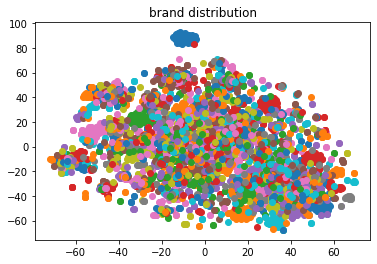

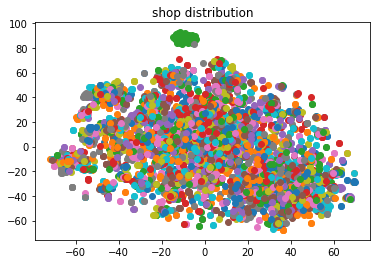

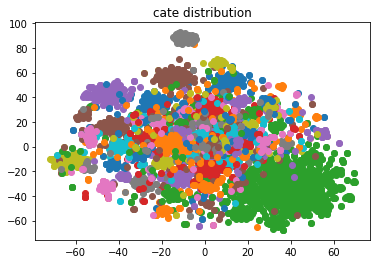

In [25]:
feed_dict_test = {input_col: list(side_info[:, i]) for i, input_col in enumerate(EGES.inputs[:-1])}
feed_dict_test[EGES.inputs[-1]] = np.zeros((len(side_info), 1), dtype=np.int32)
embedding_result = sess.run(EGES.merge_emb, feed_dict=feed_dict_test)
print('saving embedding result...')
write_embedding(embedding_result, './EGES.embed')

print('visualization...')
plot_embeddings(embedding_result[:5000, :], side_info[:5000, :])

## 当安装了tf2.x，但是代码是tf1.x 可以这样import tf

In [20]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [26]:
print(tf.__version__)

2.5.0
